In [11]:
from rasterio.warp import reproject, Resampling, calculate_default_transform
import rasterio as rio
import geopandas as gpd
import pandas as pd
import os
from shapely import wkt
from shapely.geometry import box
import leafmap.foliumap as leafmap
import folium
import rioxarray as rioxr
import matplotlib.pyplot as plt
import numpy as np
import osmnx as ox
from skimage import io
import xarray as xr
import shapely
from typing import Any, Union, Dict, List
import seaborn as sns

In [12]:
import torch
import torch.nn as nn

In [13]:
# Models
from src.modelling.unet import Unet
from src.modelling.siamunet_conc import SiamUnet_conc
from src.modelling.siamunet_diff import SiamUnet_diff
from src.modelling.fresunet import FresUNet

In [89]:
from shapely.geometry import shape as geo_shape
from rasterio.features import shapes as rio_shapes
from rasterio import features
from skimage.color import rgb2gray
from skimage.filters import sobel
from skimage.segmentation import  watershed
from pathlib import Path
from tqdm import tqdm
from abc import ABC, abstractmethod
from skimage.transform import resize
from shapely import box
from sklearn.metrics import precision_score, recall_score, roc_auc_score, auc, cohen_kappa_score , average_precision_score, f1_score
import pprint as pp

In [15]:
pd.options.display.max_columns = 50

In [16]:
from src.config import *
from src.io.utils_io import load_maxar_items, load_rs_path_toy, load_roi_town, check_dir, make_path, save_pickle
from src.stac.utils_stac import get_nearest_match_geometry_view
from src.utils import create_bbox, get_maxar_items_on_roi
from src.rs_processing.processing import crop_rs_on_shape, rasterize_shp
from src.io.utils_io import load_pair_raster,make_path,load_pickle


In [17]:
CRS = 32629
s_buffer = 157

In [18]:
urban_area = load_pickle(make_path("urban_area.pkl", processed_dir_path, "dataset"))

In [19]:
test_set= load_pickle(make_path("dataset_labelled_test.pkl", processed_dir_path, "dataset", "png", "data_labelled"))

In [20]:
dataset = load_pickle(make_path("dataset_visual_157.pkl", processed_dir_path, "dataset", "png"))

In [21]:
dataset_labelled = load_pickle(make_path("dataset_labelled.pkl", processed_dir_path, "dataset", "png", "data_labelled"))

In [24]:
dataset = load_pickle(make_path("dataset_visual_157.pkl", processed_dir_path, "dataset", "png"))

In [25]:
dataset_labelled.columns

Index(['annotation_id', 'labels_path', 'img_id', 'after_path', 'before_path',
       'urban_area_path'],
      dtype='object')

In [26]:
dataset.columns

Index(['before_path', 'after_path', 'town_name', 'geometry', 'quadkey',
       'before_href', 'before_view_off_nadir', 'before_view_azimuth',
       'before_view_incidence_angle', 'before_view_sun_azimuth',
       'before_view_sun_elevation', 'before_platform', 'before_clouds_percent',
       'after_href', 'after_view_off_nadir', 'after_view_azimuth',
       'after_view_incidence_angle', 'after_view_sun_azimuth',
       'after_view_sun_elevation', 'after_platform', 'after_clouds_percent',
       'id_pair', 'diff_view_off_nadir', 'diff_view_incidence',
       'diff_view_sun_azimuth', 'diff_avg', 'before_path_png',
       'after_path_png', 'img_id', 'urban_area_path'],
      dtype='object')

In [27]:
siamdiff_model_path = make_path("model_FC-Siam-diff_augm_custom_sb32_sp128_ep20", models_dir_path)
siamdiff_model_path = make_path("model_FC-Siam-diff_augm_default_sb32_sp96_ep20", models_dir_path)

In [28]:
def sigmoid(x):
 return 1/(1 + np.exp(-x))
    
def postprocess_siam(output): 
    output = output.detach().numpy()
    output = np.max(output, axis=1)
    output = output.squeeze(0)
    output = sigmoid(output)
    return output

def preprocess_siam(pre_img, post_img): 
    pre_img = torch.from_numpy(pre_img.transpose(2, 0, 1)).float().unsqueeze(0)
    post_img = torch.from_numpy(post_img.transpose(2, 0, 1)).float().unsqueeze(0)

    return pre_img, post_img


In [29]:
def predict_siam(model, pre_img, post_img): 
    pass

In [30]:
def load_pt_model(dict_model): 
    
    path = dict_model["path"]
    args = dict_model["input"]
    
    model = dict_model["model"](*args)
    
    model.load_state_dict(torch.load(path))
    model.eval()
    return model

def load_changeos(): 
    pass

def load_sfa():
    pass



In [31]:
def init_models_entry():
    models_entry = {
                "Unet":
                {
                    "path":"", 
                    "model":Unet,
                    "input":(2*3, 2), 
                    "builder": load_pt_model,
                    "predictor":predict_siam, 
                    "postprocess":postprocess_siam, 
                    "preprocess":preprocess_siam

                },
                "FC-Siam-conc":
                {
                    "path":"", 
                    "model":SiamUnet_conc,  
                    "input":(3, 2),
                    "builder": load_pt_model,
                    "predictor":predict_siam, 
                    "postprocess":postprocess_siam, 
                    "preprocess":preprocess_siam

                },
                "FC-Siam-diff":
                {
                    "path":siamdiff_model_path, 
                    "model":SiamUnet_diff,  
                    "input":(3, 2), 
                    "builder": load_pt_model,
                    "predictor":predict_siam,
                    "postprocess":postprocess_siam, 
                    "preprocess":preprocess_siam
    
                }, 
                "FresUNet":
                {
                    "path":"",
                    "model":FresUNet,  
                    "input":(2*3, 2),
                    "builder": load_pt_model,
                    "predictor":predict_siam,
                    "postprocess":postprocess_siam, 
                    "preprocess":preprocess_siam

                }, 
                "changeos": 
                {
                    "path":"",
                    "model":None,  
                    "input":None,
                    "builder": load_changeos,
                    "predictor":None

                },
                "sfa": 
                {
                    "path":"",
                    "model":None,  
                    "input":None,
                    "builder": load_sfa, 
                    "predictor":None
                }
            }
    return models_entry


In [32]:
class ModelFactory:
    def __init__(self):
        self.models_entry = models_entry

    def load(self, model_key: str, *args): 

        dict_model = {k:v for k,v in self.models_entry[model_key].items() if k!="builder"}
        builder = self.models_entry[model_key]["builder"]

        return builder(dict_model)

    def predict(self, model_key: str, *args): 

        dict_model = {k:v for k,v in self.models_entry[model_key].items() if k!="predictor"}
        predictor = self.models_entry[model_key]["predictor"]

        return predictor(dict_model)
    

In [45]:
class InferenceModel:
    def __init__(self, model_entry, model_name, model=None): 
        self.model_entry = model_entry
        
        if model_name is None and model is None: 
            raise ValueError("Please provide a least model_name or (model, model_name)")
        
        self.model_name = model_name
        self.model = self.init_model(model_name, model)
            
    def init_model(self, model_name, model):
        if model is None:
            return ModelFactory().load(model_name)
        else: 
            return model

    def postprocessing(self, out):
        return self.model_entry["postprocess"](out)

    def preprocessing(self, pre_img, post_img):
        return self.model_entry["preprocess"](pre_img, post_img)
        
    def predict(self, pre_path=None, post_path=None): 

        pre_img = io.imread(pre_path)
        post_img = io.imread(post_path)
        
        pre_img, post_img = self.preprocessing(pre_img, post_img)
        output =  self.model(pre_img, post_img)
        output = self.postprocessing(output)

        return output

In [46]:
def inference_on_sample(sample: pd.Series, model_name = "FC-Siam-diff"):    
    (
        b_path, 
        a_path, 
        label, 
        img_id
    )= (
        sample["before_path"], 
        sample["after_path"], 
        sample["labels_path"], 
        sample["img_id"]
    )


    model_entry = models_entry[model_name]
    
    output = InferenceModel(model_entry, model_name).predict(b_path, a_path)

    return output

In [47]:
MODELS_VERSION = {
    "FC-Siam-diff": {
        "model_FC-Siam-diff_augm_default_sb32_sp96_ep20": make_path("model_FC-Siam-diff_augm_default_sb32_sp96_ep20", models_dir_path),
        "model_FC-Siam-diff_augm_custom_sb32_sp128_ep20": make_path("model_FC-Siam-diff_augm_custom_sb32_sp128_ep20", models_dir_path),
    },
    "FC-Siam-conc":{
        "model_FC-Siam-conc_augm_default_sb32_sp96_ep20": make_path("model_FC-Siam-conc_augm_default_sb32_sp96_ep20", models_dir_path)
    }, 
    "FresUNet":{
        "model_FresUNet_augm_default_sb32_sp96_ep20": make_path("model_FresUNet_augm_default_sb32_sp96_ep20", models_dir_path)
    }
}

In [52]:
sample = test_set.sample()

In [53]:
sample = sample.squeeze()

In [54]:
sample

annotation_id                                                   16
labels_path      /home/rustt/Documents/Projects/building_damage...
img_id                        465955c3-57fd-4b53-b347-1e9ea61d26d7
after_path       /home/rustt/Documents/Projects/building_damage...
before_path      /home/rustt/Documents/Projects/building_damage...
Name: 15, dtype: object

In [55]:
models_entry = init_models_entry()
model_name = "FresUNet"
version = "model_FresUNet_augm_default_sb32_sp96_ep20"

models_entry[model_name]["path"] = MODELS_VERSION[model_name][version]

output = inference_on_sample(sample, model_name=model_name)

In [56]:
output.shape

(1024, 1024)

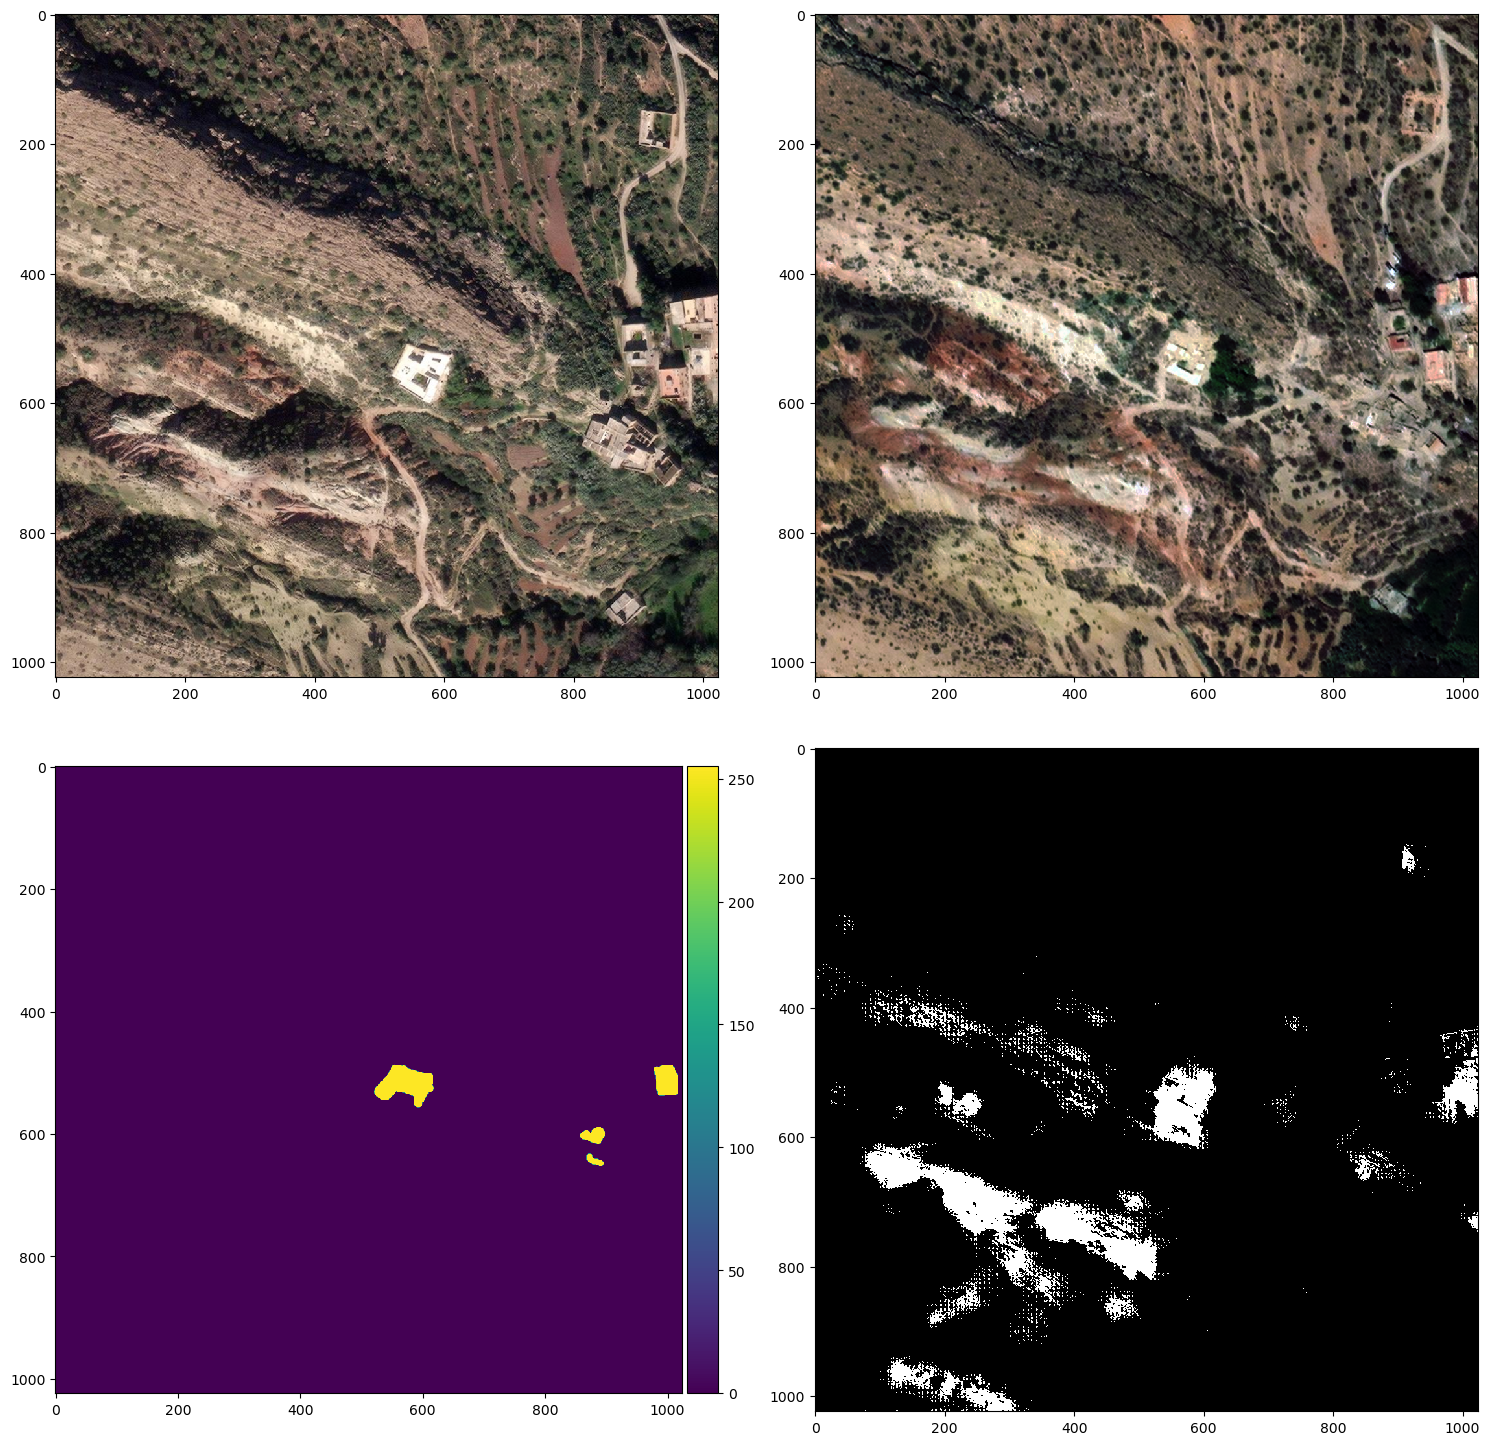

In [93]:
    (
        b_path, 
        a_path, 
        label, 
        img_id
    )= (
        sample["before_path"], 
        sample["after_path"], 
        sample["labels_path"], 
        sample["img_id"]
    )
plt.figure(figsize=(15, 15))
plt.subplot(2, 2, 1)
io.imshow(b_path)
plt.subplot(2, 2, 2)
io.imshow(a_path)
plt.subplot(2, 2, 3)
io.imshow(label)
plt.subplot(2, 2, 4)
io.imshow( output  < 0.7)

In [94]:
img_id

'465955c3-57fd-4b53-b347-1e9ea61d26d7'

# Evaluation

In [145]:
import h3pandas as h3
from rasterstats import zonal_stats
from typing import Tuple
import geoplot as gplt
import geoplot.crs as gcrs

In [127]:
def processing_pred_eval(output): 
    
    output =  resize(output,(1024, 1024), anti_aliasing=True, preserve_range=True)
    output = (1 - output)

    return output

def processing_label_eval(label_path: str): 
    
    arr_label = io.imread(label_path)
    arr_label =  resize(arr_label,(1024, 1024), anti_aliasing=True, preserve_range=True)
    arr_label =  np.where(arr_label > 0, 1, 0)

    return arr_label

In [128]:
def show_items_from_id(img_id: str, dataset): 
    sample = dataset[dataset.img_id == img_id].squeeze()
    a_path, b_path, label_path = sample["a_path"], sample["b_path"], row["label_path"]
    
    plt.figure(figsize=(20, 8))
    
    plt.subplots(1, 3, 1)
    io.imshow(b_path)
    plt.axis("off")
    
    plt.subplots(1, 3, 1)
    io.imshow(a_path)
    plt.axis("off")
    
    plt.subplots(1, 3, 1)
    io.imshow(label_path)
    plt.axis("off")

In [129]:
def get_raster_stats_on_poly(urban: gpd.GeoDataFrame, rs: xr.DataArray) -> gpd.GeoDataFrame: 

    arr = rs.sel(band=1).data
    zs = zonal_stats(urban, 
                     arr, 
                     affine=rs.rio.transform(), 
                     stats=['count', 'mean', "max",'median', 'majority', 'sum'])
    
    zs = pd.DataFrame(zs)
    urban_zs = pd.concat([urban, zs], axis=1)
    urban_zs["sum"] = shift_range_values(urban_zs["sum"])

    return urban_zs

def mask_array_to_geotiff(arr, rs_path_src: str, out_path: str):
    with rio.open(rs_path_src, "r") as rs_src: 
        meta = rs_src.meta.copy()
        meta.update(
            {
                "driver": "GTiff", 
                'count': 1, 
                'dtype': 'float32'
            })
        with rio.open(out_path, "w", **meta) as dest:
            dest.write_band(1,arr)
    return out_path
    
def shift_range_values(arr, new_bounds=[0, 1]): 
    old_range = (np.max(arr) - np.min(arr))  
    new_range = (new_bounds[1] - new_bounds[0])  
    shit_arr = (((arr - np.min(arr)) * new_range) / old_range) + new_bounds[0]
    return shit_arr

In [130]:
def get_classification_metrics(urban_zs_label, urban_zs_pred, th_true=0, plot=True):
    
    def _get_metrics_plot(metrics, names: List[str]):
        metrics = metrics[names+["th"]]
        metrics = metrics.melt(id_vars="th", var_name="metric", value_name="score")
        plt.figure()
        sns.lineplot(data=metrics, x="th", y="score", hue="metric")
        plt.title("Classification metrics based on decision threshold")
        return metrics 

    def get_max_metrics(metrics, names): 
        max_metrics = {}
        metrics.set_index("th")
        for m in names:
            max_metrics[m] = metrics[m].max()
        return max_metrics 

    metrics = []
    true_labels = (urban_zs_label["sum"] > th_true).astype(int).values    

    print(f"Support : {(urban_zs_label['sum'] > th_true).astype(int).value_counts()}")
    print('----')
    
    for th in np.arange(0, 1, 0.02): 
        pred = (urban_zs_pred["sum"] > th).astype(int).values 
    
        metrics.append({
            "th":th,
            "precision": precision_score(true_labels, pred), 
            "recall": recall_score(true_labels, pred), 
            "f1_score": f1_score(true_labels, pred),
            "kappa_score":cohen_kappa_score(true_labels, pred), 
            "roc_auc_score": roc_auc_score(true_labels, pred),
            "AP": average_precision_score(true_labels, pred),
        })
        
    metrics = pd.DataFrame(metrics)
    
    plot_metrics = ["precision", "recall", "f1_score"]
    max_metrics = ["kappa_score", "roc_auc_score", "AP"]
    
    _ = _get_metrics_plot(metrics, plot_metrics)

    max_metrics = get_max_metrics(metrics, max_metrics)
    print("Global metric (max)")
    pp.pprint(max_metrics)
    print('----')

    
    return metrics


In [131]:
def visualize_damage_map(urban_zs_pred, bounds: Tuple[float], urban_zs_label=None, img_id=None):

    x_min, y_min, x_max, y_max = bounds
    background = gpd.GeoDataFrame(geometry=[box(x_min, y_min, x_max, y_max)], crs=urban_zs_label.crs)

    if urban_zs_label is None:
        urban_zs_label.plot(column='sum',cmap="RdBu_r", legend=True, figsize=(15, 5), legend_kwds={"shrink":.5})
        plt.axis("off")
        plt.title(f"Damages map for {img_id}" if img_id else "Damages map")
        background.plot(color="grey", zorder=0)

    else:
        fig, axes = plt.subplots(1, 2, figsize=(18, 8))
        urban_zs_label.plot(column='sum', cmap="RdBu_r", legend=True, ax=axes[0], legend_kwds={"shrink":.5})
        axes[0].set_axis_off()
        axes[0].set_title(f"True damages map for {img_id}" if img_id else "True damages map")
        background.plot(ax=axes[0], color="grey", zorder=0)


        urban_zs_pred.plot(column='sum',cmap="RdBu_r", legend=True, ax=axes[1], legend_kwds={"shrink":.5})
        axes[1].set_axis_off()
        axes[1].set_title(f"Predicted damages map for {img_id}" if img_id else "Predicted damages map")
        background.plot(ax=axes[1], color="grey", zorder=0)



In [138]:
def eval_on_sample(output: np.ndarray, label_path:str, a_path: str, img_id: str,  urban_path: str, visualize=True) -> pd.DataFrame:
    
    pred = processing_pred_eval(output)
    label = processing_label_eval(label_path)

    urban = gpd.read_file(urban_path)

    # change io operation path or remove files
    rs_pred_path = mask_array_to_geotiff(pred, rs_path_src=a_path, out_path="out_test_pred.tif")
    rs_label_path = mask_array_to_geotiff(label, rs_path_src=a_path, out_path="out_test_label.tif")

    rs_pred = rioxr.open_rasterio(rs_pred_path)
    rs_label = rioxr.open_rasterio(rs_label_path)

    urban_zs_pred = get_raster_stats_on_poly(urban, rs_pred)
    urban_zs_label = get_raster_stats_on_poly(urban, rs_label)
    
    if visualize: 
        visualize_damage_map(urban_zs_pred=urban_zs_pred,
                             bounds=rs_pred.rio.bounds(),
                             urban_zs_label=urban_zs_label, 
                             img_id=img_id)

    metrics = get_classification_metrics(urban_zs_label, urban_zs_pred, plot=visualize)

    return dict(
        metrics=metrics, 
        urban_pred=urban_zs_pred, 
        urban_label=urban_zs_label
    )

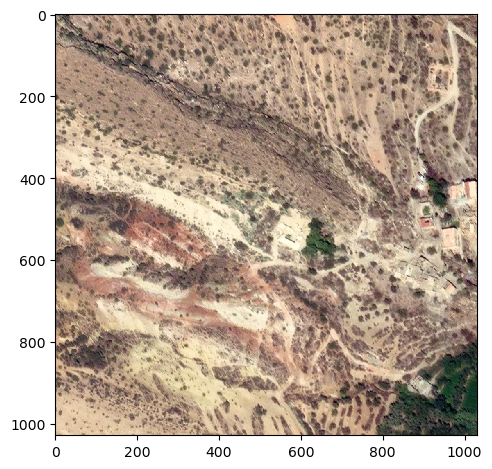

In [100]:
io.imshow(dataset.loc[dataset.img_id == img_id, "after_path"].item())

Support : sum
0    88
1    24
Name: count, dtype: int64
----
Global metric (max)
{'AP': 0.4604978354978355,
 'kappa_score': 0.5078125,
 'roc_auc_score': 0.765151515151515}
----


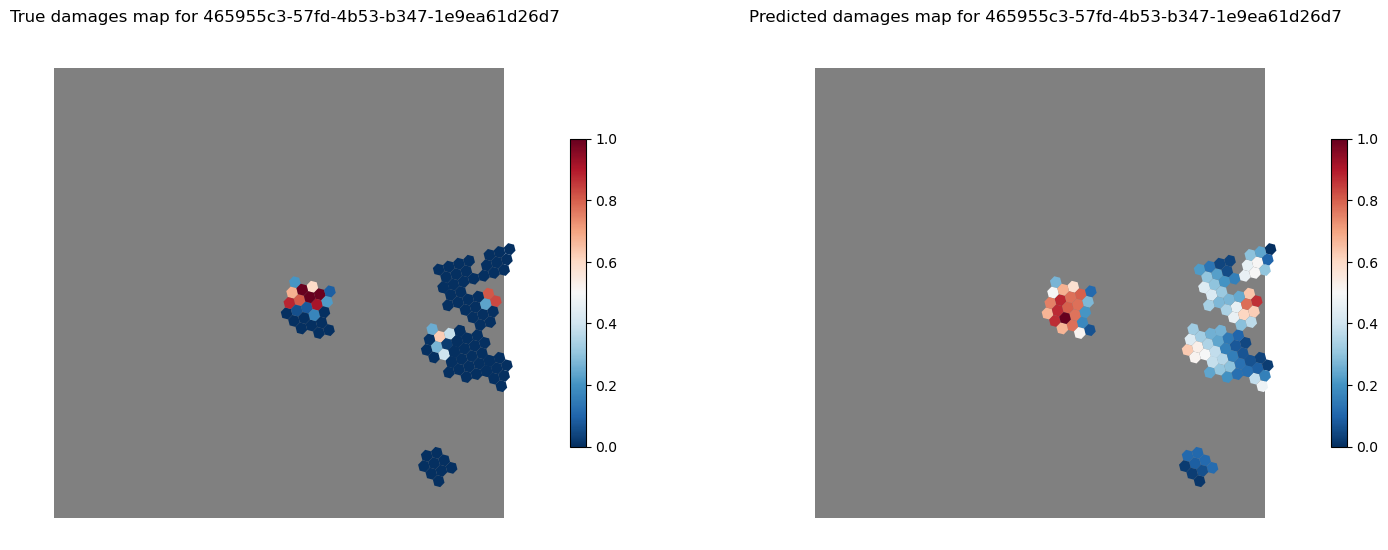

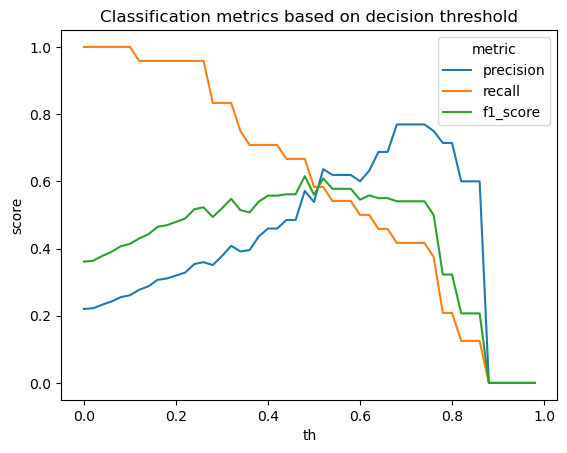

In [139]:
img_id = sample.img_id

label_path = sample.labels_path
a_path = dataset.loc[dataset.img_id == img_id, "after_path"].item()
urban_path = urban_area.loc[urban_area.img_id == img_id, "urban_area_path"].item()

res = eval_on_sample(output=output, 
                         label_path=label_path, 
                         a_path=a_path,
                         img_id=img_id,
                         urban_path=urban_path, 
                         visualize=True)

Comment interpeter carte de dommages : % de pixels détruits ? Ramener à un nombre de batiments ?

In [582]:
np.corrcoef(res["urban_label"]["sum"], res["urban_pred"]["sum"])

array([[1.       , 0.4402899],
       [0.4402899, 1.       ]])

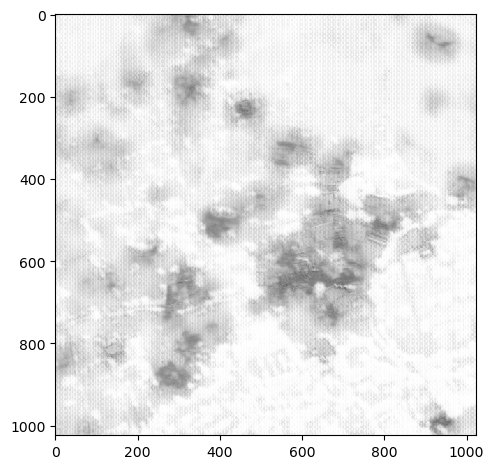

In [573]:
io.imshow(output)

Add spatial correlation ?

In [473]:
res["metrics"]

th  precision    recall  f1_score  kappa_score  roc_auc_score  \
0   0.00   0.225490  1.000000  0.368000     0.005621       0.506250   
1   0.02   0.239583  1.000000  0.386555     0.041066       0.543750   
2   0.04   0.255556  1.000000  0.407080     0.079744       0.581250   
3   0.06   0.270588  1.000000  0.425926     0.114777       0.612500   
4   0.08   0.282051  0.956522  0.435644     0.138518       0.628261   
5   0.10   0.301370  0.956522  0.458333     0.179786       0.659511   
6   0.12   0.296875  0.826087  0.436782     0.161210       0.631793   
7   0.14   0.321429  0.782609  0.455696     0.203561       0.653804   
8   0.16   0.346154  0.782609  0.480000     0.246765       0.678804   
9   0.18   0.346154  0.782609  0.480000     0.246765       0.678804   
10  0.20   0.340000  0.739130  0.465753     0.230312       0.663315   
11  0.22   0.354167  0.739130  0.478873     0.253477       0.675815   
12  0.24   0.377778  0.739130  0.500000     0.290231       0.694565   
13  0.26   0.395349  0.739130  0.515152     0.316183       0.707065   
14  0.28   0.425000  0.739130  0.539683     0.357496       0.725815   
15  0.30   0.459459  0.739130  0.566667     0.401965       0.744565   
16  0.32   0.459459  0.739130  0.566667     0.401965       0.744565   
17  0.34   0.459459  0.739130  0.566667     0.401965       0.744565   
18  0.36   0.444444  0.695652  0.542373     0.370957       0.722826   
19  0.38   0.483871  0.652174  0.555556     0.402321       0.726087   
20  0.40   0.483871  0.652174  0.555556     0.402321       0.726087   
21  0.42   0.518519  0.608696  0.560000     0.420164       0.723098   
22  0.44   0.538462  0.608696  0.571429     0.438328       0.729348   
23  0.46   0.500000  0.521739  0.510638     0.366069       0.685870   
24  0.48   0.478261  0.478261  0.478261     0.328261       0.664130   
25  0.50   0.523810  0.478261  0.500000     0.364554       0.676630   
26  0.52   0.523810  0.478261  0.500000     0.364554       0.676630   
27  0.54   0.500000  0.434783  0.465116     0.324879       0.654891   
28  0.56   0.500000  0.347826  0.410256     0.277964       0.623913   
29  0.58   0.533333  0.347826  0.421053     0.297146       0.630163   
30  0.60   0.500000  0.304348  0.378378     0.251973       0.608424   
31  0.62   0.461538  0.260870  0.333333     0.205145       0.586685   
32  0.64   0.454545  0.217391  0.294118     0.174900       0.571196   
33  0.66   0.400000  0.173913  0.242424     0.123852       0.549457   
34  0.68   0.400000  0.173913  0.242424     0.123852       0.549457   
35  0.70   0.400000  0.173913  0.242424     0.123852       0.549457   
36  0.72   0.400000  0.173913  0.242424     0.123852       0.549457   
37  0.74   0.444444  0.173913  0.250000     0.142262       0.555707   
38  0.76   0.444444  0.173913  0.250000     0.142262       0.555707   
39  0.78   0.428571  0.130435  0.200000     0.106936       0.540217   
40  0.80   0.428571  0.130435  0.200000     0.106936       0.540217   
41  0.82   0.400000  0.086957  0.142857     0.068576       0.524728   
42  0.84   0.400000  0.086957  0.142857     0.068576       0.524728   
43  0.86   0.250000  0.043478  0.074074     0.008471       0.502989   
44  0.88   0.500000  0.043478  0.080000     0.045912       0.515489   
45  0.90   1.000000  0.043478  0.083333     0.065952       0.521739   
46  0.92   1.000000  0.043478  0.083333     0.065952       0.521739   
47  0.94   1.000000  0.043478  0.083333     0.065952       0.521739   
48  0.96   1.000000  0.043478  0.083333     0.065952       0.521739   
49  0.98   1.000000  0.043478  0.083333     0.065952       0.521739   

    avg_precision  
0        0.225490  
1        0.239583  
2        0.255556  
3        0.270588  
4        0.279497  
5        0.297976  
6        0.284080  
7        0.300096  
8        0.319447  
9        0.319447  
10       0.309557  
11       0.320028  
12       0.337479  
13       0.350467  
14       0.372383  
15       0.397853  
16       0.397853  
17       0.397853  
18  

## Full pipeline

In [511]:
def postprocess_inference(output: np.ndarray, a_path: str, img_id: str,  urban_path: str, visualize=True): 
    
    pred = processing_pred_eval(output)
    urban = gpd.read_file(urban_path)

    # change io operation path or remove files
    rs_pred_path = mask_array_to_geotiff(pred, rs_path_src=a_path, out_path="out_test_pred.tif")

    rs_pred = rioxr.open_rasterio(rs_pred_path)
    urban_zs_pred = get_raster_stats_on_poly(urban, rs_pred)
    
    # add save plot
    if visualize: 
        visualize_damage_map(urban_zs_pred, img_id=img_id)

    return urban_zs_pred


In [ ]:
def pipeline_inference(dataset, urban_area, model_name, version, visualize=True):
    
    models_entry = init_models_entry()
    models_entry[model_name]["path"] = MODELS_VERSION[model_name][version]

    damages_map = []

    # check if columns are ok 
    # check if items in dataset are present in urban area
    for i, row in dataset.iterrows():
        a_path, img_id = row["after_path"], row["img_id"]
        urban_path = urban_area.loc[urban_area.img_id == img_id, "urban_area_path"]

        output = inference_on_sample(row, model_name=model_name)
        urban_zs_pred = postprocess_inference(output=output, a_path=a_path, urban_path, visualize=True)
        damages_map.append(urban_zs_pred)

    return damages_map
    

## Annexes

### Kernel density plot

In [132]:
label_path = sample.labels_path
a_path = dataset.loc[dataset.img_id == img_id, "after_path"].item()
urban_path = urban_area.loc[urban_area.img_id == img_id, "urban_area_path"].item()
visualize=True

In [371]:
pred = processing_pred_eval(output)
label = processing_label_eval(label_path)

urban = gpd.read_file(urban_path)

# change io operation path or remove files
rs_pred_path = mask_array_to_geotiff(pred, rs_path_src=a_path, out_path="out_test_pred.tif")
rs_label_path = mask_array_to_geotiff(label, rs_path_src=a_path, out_path="out_test_label.tif")

rs_pred = rioxr.open_rasterio(rs_pred_path)
rs_label = rioxr.open_rasterio(rs_label_path)

urban_zs_pred = get_raster_stats_on_poly(urban, rs_pred)
urban_zs_label = get_raster_stats_on_poly(urban, rs_label)

In [372]:
urban_zs_pred.head(2)

id_hex  index  grid_resol  cell_area  \
0  8d398306626a03f      0          13  47.640567   
1  8d398306624cd7f      0          13  47.640410   

                                            geometry       max      mean  \
0  POLYGON ((572348.926 3452276.357, 572353.004 3...  0.400928  0.136237   
1  POLYGON ((572367.595 3452248.159, 572371.672 3...  0.352490  0.089648   

   count       sum    median  majority  
0    509  0.269015  0.121139  0.010382  
1    511  0.177062  0.051914  0.003849

In [373]:
urban_zs_pred_test = urban_zs_pred[["geometry", "sum"]].copy()

<Axes: >

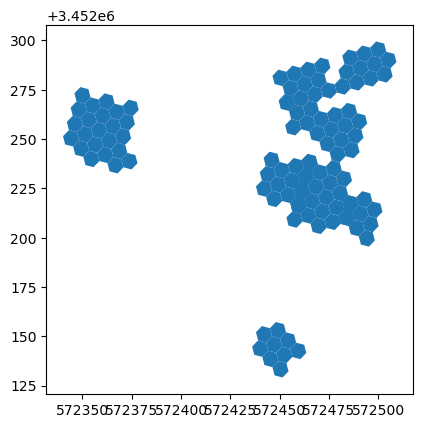

In [374]:
urban_zs_pred_test.plot()

In [375]:
urban_zs_pred_test["sum"] = urban_zs_pred_test["sum"].fillna(0)

In [376]:
urban_zs_pred_test = urban_zs_pred_test.to_crs(4326)
urban_zs_pred_test = urban_zs_pred_test.h3.polyfill_resample(14)
urban_zs_pred_test = urban_zs_pred_test.to_crs(CRS)

In [377]:
urban_zs_pred_test["sum"] = urban_zs_pred_test["sum"].fillna(0)

In [378]:
urban_zs_pred_test.shape

(784, 3)

In [379]:
urban_zs_pred_test = urban_zs_pred_test.reset_index()

In [380]:
urban_zs_pred_test = get_raster_stats_on_poly(urban_zs_pred_test[["geometry"]], rs_pred)

In [381]:
urban_zs_pred_test.shape

(784, 7)

<Axes: >

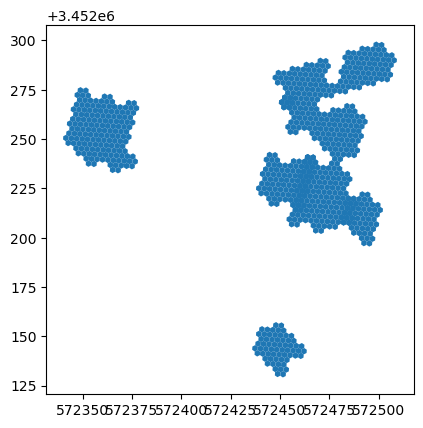

In [382]:
urban_zs_pred_test.plot()

In [383]:
urban_zs_pred_test.geometry = urban_zs_pred_test.centroid

In [384]:
urban_zs_pred_test.shape

(784, 7)

In [396]:
urban_zs_pred_test["cnt_cell"] = np.round(urban_zs_pred_test["sum"] * 100)

In [394]:
np.min(urban_zs_pred_test["sum"])

0.0

In [413]:
urban_zs_pred_test.cnt_cell = urban_zs_pred_test.cnt_cell.fillna(0)

In [ ]:
urban_zs_pred_test.reindex(urban_zs_pred_test.index.repeat(urban_zs_pred_test['sum']))

In [416]:
urban_zs_pred_test.isna().sum()

geometry     0
max         32
mean        32
count        0
sum         32
median      32
majority    32
cnt_cell     0
dtype: int64

In [419]:
urban_density = urban_zs_pred_test.apply(np.repeat, repeats=urban_zs_pred_test['cnt_cell'])


In [420]:
urban_density.shape

(23245, 8)

In [430]:
# Get X and Y coordinates of well points
x_sk = urban_density["geometry"].x
y_sk = urban_density["geometry"].y

# Get minimum and maximum coordinate values of well points
min_x_sk, min_y_sk, max_x_sk, max_y_sk = urban_density.total_bounds

# Create a cell mesh grid
# Horizontal and vertical cell counts should be the same
XX_sk, YY_sk = np.mgrid[min_x_sk:max_x_sk:1000j, min_y_sk:max_y_sk:1000j]

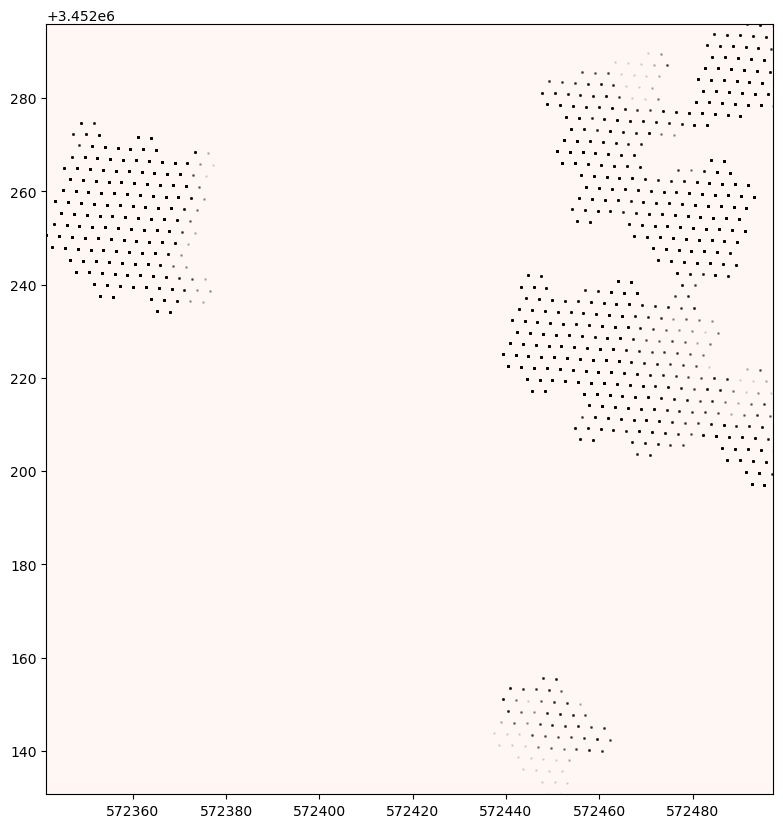

In [431]:
from sklearn.neighbors import KernelDensity
# Create 2-D array of the coordinates (paired) of each cell in the mesh grid
positions_sk = np.vstack([XX_sk.ravel(), YY_sk.ravel()]).T

# Create 2-D array of the coordinate values of the well points
Xtrain_sk = np.vstack([x_sk, y_sk]).T

# Get kernel density estimator (can change parameters as desired)
kde_sk = KernelDensity(bandwidth = 0.04, metric = 'euclidean', kernel = 'gaussian', algorithm = 'auto')

# Fit kernel density estimator to wells coordinates
kde_sk.fit(Xtrain_sk)

# Evaluate the estimator on coordinate pairs
Z_sk = np.exp(kde_sk.score_samples(positions_sk))

# Reshape the data to fit mesh grid
Z_sk = Z_sk.reshape(XX_sk.shape)

# Plot data
fig, ax = plt.subplots(1, 1, figsize = (10, 10))
ax.imshow(np.rot90(Z_sk), cmap = "RdPu", extent = [min_x_sk, max_x_sk, min_y_sk, max_y_sk])
ax.plot(x_sk, y_sk, 'k.', markersize = 2, alpha = 0.1)
#counties_wgs.plot(ax = ax, color = 'none', edgecolor = 'dimgray')

Text(0.5, 1.0, 'Damages map for 465955c3-57fd-4b53-b347-1e9ea61d26d7')

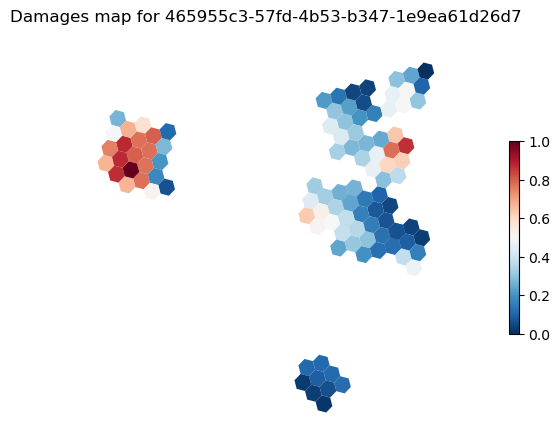

In [210]:
urban_zs_pred.plot(column='sum',cmap="RdBu_r", legend=True, figsize=(15, 5), legend_kwds={"shrink":.5})
plt.axis("off")
plt.title(f"Damages map for {img_id}" if img_id else "Damages map")


<Axes: >

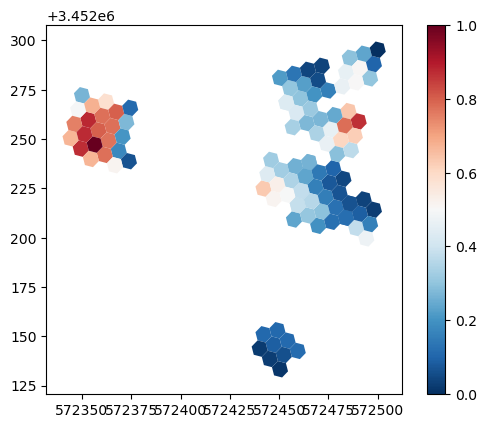

In [219]:
urban_zs_pred.plot(column='sum',
                   cmap="RdBu_r", 
                   legend=True, 
                   #legend_kwds={"shrink":.5}, 
                   )

In [423]:
urban_density

geometry       max      mean  count       sum  \
0    POINT (572351.195 3452269.655)  0.400928  0.271419     71  0.471347   
0    POINT (572351.195 3452269.655)  0.400928  0.271419     71  0.471347   
0    POINT (572351.195 3452269.655)  0.400928  0.271419     71  0.471347   
0    POINT (572351.195 3452269.655)  0.400928  0.271419     71  0.471347   
0    POINT (572351.195 3452269.655)  0.400928  0.271419     71  0.471347   
..                              ...       ...       ...    ...       ...   
783  POINT (572468.638 3452265.154)  0.223289  0.118097     75  0.210285   
783  POINT (572468.638 3452265.154)  0.223289  0.118097     75  0.210285   
783  POINT (572468.638 3452265.154)  0.223289  0.118097     75  0.210285   
783  POINT (572468.638 3452265.154)  0.223289  0.118097     75  0.210285   
783  POINT (572468.638 3452265.154)  0.223289  0.118097     75  0.210285   

       median  majority  cnt_cell  
0    0.275948  0.127501      47.0  
0    0.275948  0.127501      47.0  
0    0.275948  0.127501      47.0  
0    0.275948  0.127501      47.0  
0    0.275948  0.127501      47.0  
..        ...       ...       ...  
783  0.117019  0.031190      21.0  
783  0.117019  0.031190      21.0  
783  0.117019  0.031190      21.0  
783  0.117019  0.031190      21.0  
783  0.117019  0.031190      21.0  

[23245 rows x 8 columns]

<Axes: xlabel='None', ylabel='None'>

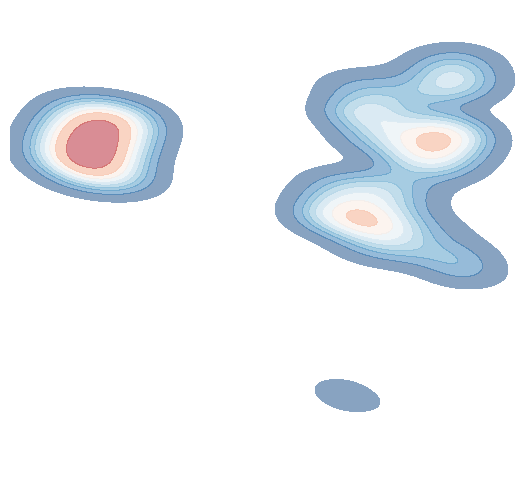

In [425]:
# Create subplots
#fig, ax = plt.subplots(1, 1, figsize = (10, 10))

# Plot data
gplt.kdeplot(urban_density.to_crs(4326),
                  shade = True,
                 cmap = "RdBu_r",# "RdPu",
                 alpha = 0.5)
#plt.axis("off")
#plt.title(f"Damages map for {img_id}" if img_id else "Damages map")

<Axes: xlabel='None', ylabel='None'>

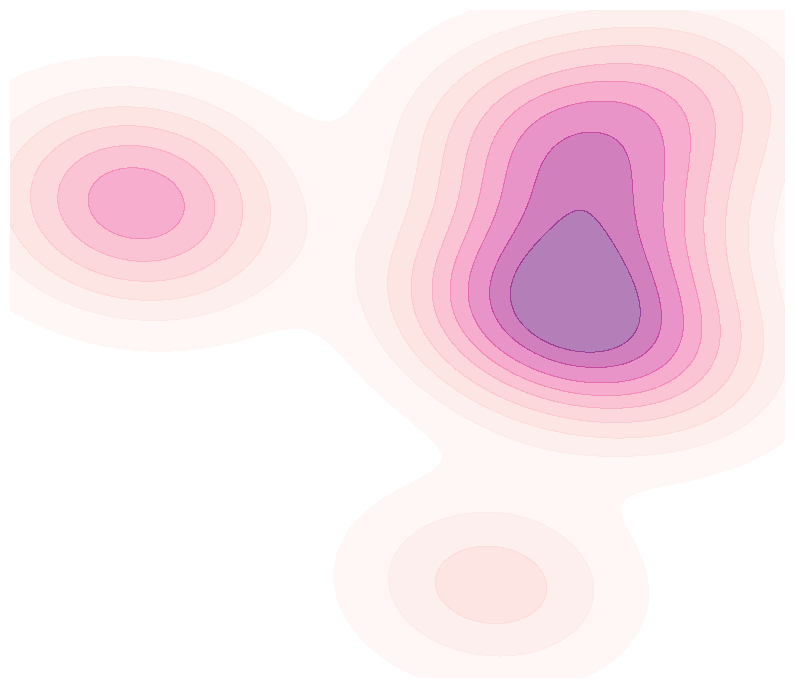

In [168]:
# Create subplots
fig, ax = plt.subplots(1, 1, figsize = (10, 10))

# Plot data
gplt.kdeplot(pts_urban_zs_pred_test,
             ax=ax,shade = True,
             cmap = "RdPu",
             alpha = 0.5)

In [37]:
sample.img_id.item()

'49a91dea-ed40-4772-b6b9-f9683509b8ac'

In [35]:
urban_test = gpd.read_file(urban_area.loc[urban_area["img_id"] == sample.img_id.item(), "urban_area_path"].item())
#urban_test = gpd.read_file(urban_area.loc[urban_area.img_id == "d56aa5a0-6a45-44dd-a227-9a5eab169393", "urban_area_path"].item())

<Axes: >

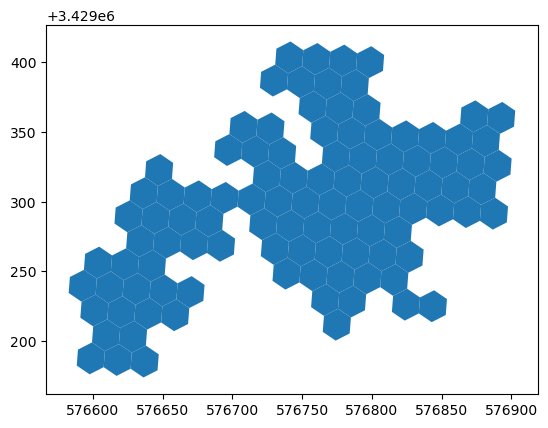

In [36]:
urban_test.plot()

### Statistics

In [75]:
from rasterstats import zonal_stats, point_query

In [318]:
sample.after_path.item()

'/home/rustt/Documents/Projects/building_damage/morocco_damage_building/data/processed/dataset/png/data_labelled/after/d56aa5a0-6a45-44dd-a227-9a5eab169393.png'

In [319]:
sample

annotation_id                                        labels_path  \
18             19  /home/rustt/Documents/Projects/building_damage...   

                                  img_id  \
18  d56aa5a0-6a45-44dd-a227-9a5eab169393   

                                           after_path  \
18  /home/rustt/Documents/Projects/building_damage...   

                                          before_path  
18  /home/rustt/Documents/Projects/building_damage...

In [53]:
img_id = sample.img_id.item()
a_path = dataset[dataset["img_id"] == img_id].after_path.item()

<Axes: >

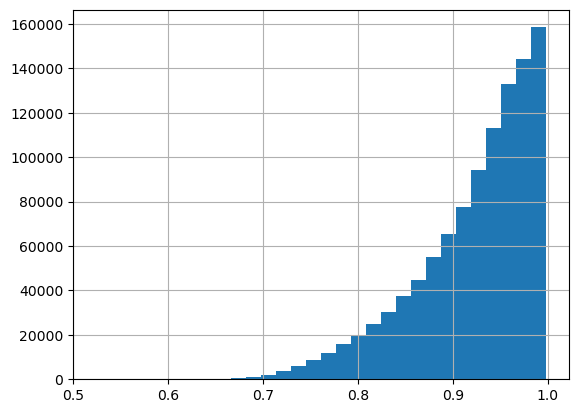

In [149]:
pd.Series(image.flatten()).hist(bins=30)

In [ ]:
image =  resize(output,(1024, 1024), anti_aliasing=True, preserve_range=True)
rs_pred = (1-image).copy()#.astype(np.uint8)

In [193]:
out_path = mask_array_to_geotiff(rs_pred, rs_path_src=a_path, out_path="out_test_pred.tif")

In [212]:
arr_label = io.imread(label)
arr_label =  resize(arr_label,(1024, 1024), anti_aliasing=True, preserve_range=True)
arr_label =  np.where(arr_label > 0, 1, 0)

In [213]:
arr_label.shape

(1024, 1024)

In [214]:
out_path_label = mask_array_to_geotiff(arr_label, rs_path_src=a_path, out_path="out_test_label.tif")

In [215]:
rs_pred = rioxr.open_rasterio(out_path)
rs_label = rioxr.open_rasterio(out_path_label)

In [216]:
#pd.Series(rs.data.squeeze().flatten()).value_counts()

In [218]:
arr_pred = rs_pred.sel(band=1).data
arr_label = rs_label.sel(band=1).data

In [219]:
np.unique(arr_label.flatten())

array([0., 1.], dtype=float32)

In [252]:
zs_pred = zonal_stats(urban_test, arr_pred, affine=rs_pred.rio.transform(), stats=['count', 'mean', "max",'median', 'majority', 'sum'])

In [253]:
zs_label = zonal_stats(urban_test, arr_label, affine=rs_label.rio.transform(), stats=['count', 'mean', "max",'median', 'majority', 'sum'])

In [254]:
zs_pred = pd.DataFrame(zs_pred)
zs_label = pd.DataFrame(zs_label)

In [255]:
urban_zs_pred = pd.concat([urban_test, zs_pred], axis=1)
urban_zs_label = pd.concat([urban_test, zs_label], axis=1)

In [259]:
urban_zs_pred["sum"] = shift_range_values(urban_zs_pred["sum"])
urban_zs_label["sum"] = shift_range_values(urban_zs_label["sum"])

### Visualization

Text(0.5, 1.0, 'true label for 49a91dea-ed40-4772-b6b9-f9683509b8ac')

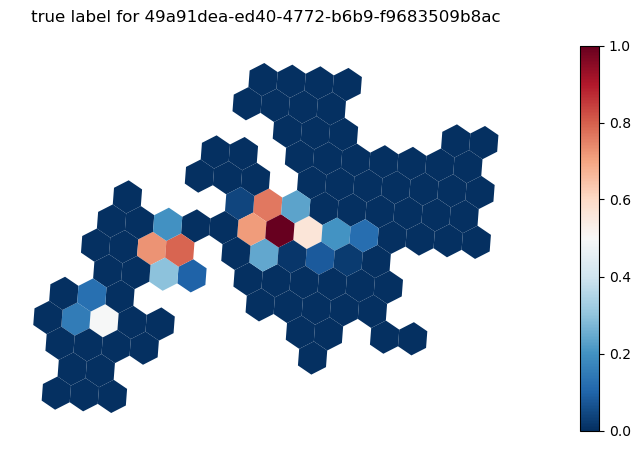

In [315]:
#fig, ax = plt.subplots(1, 1, figsize=(10, 10))
urban_zs_label.plot(column='sum',cmap="RdBu_r", legend=True, figsize=(15, 5))
plt.axis("off")
plt.title(f"true label for {img_id}")

Text(0.5, 1.0, 'prediction for 49a91dea-ed40-4772-b6b9-f9683509b8ac')

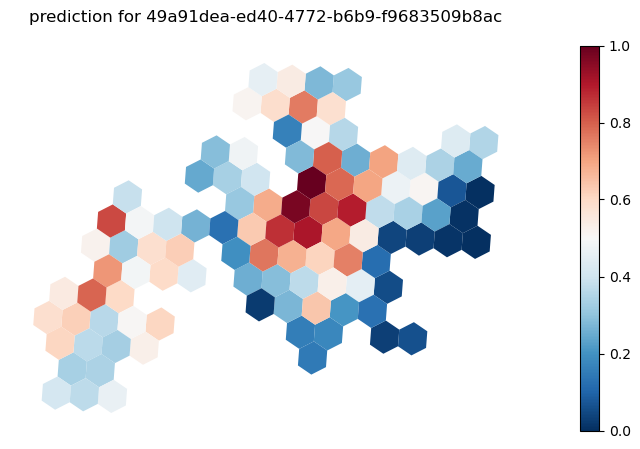

In [260]:
#shift to à-1
urban_zs_pred.plot(column='sum',cmap="RdBu_r", legend=True, figsize=(15, 5))
plt.axis("off")
plt.title(f"prediction for {img_id}")

In [263]:
urban_zs_pred["pred"] = urban_zs_pred["sum"].copy()

In [264]:
urban_zs_label["label"].describe()

count    103.000000
mean       0.066760
std        0.190377
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max        1.000000
Name: label, dtype: float64

In [265]:
urban_zs_label["label"] = (urban_zs_label["sum"] > 0).astype(int)

In [266]:
from sklearn.metrics import precision_score, recall_score, f1_score

In [307]:
metrics = pd.DataFrame(metrics)

In [308]:
metrics = metrics.melt(id_vars="th", var_name="metric", value_name="score")

<Axes: xlabel='th', ylabel='score'>

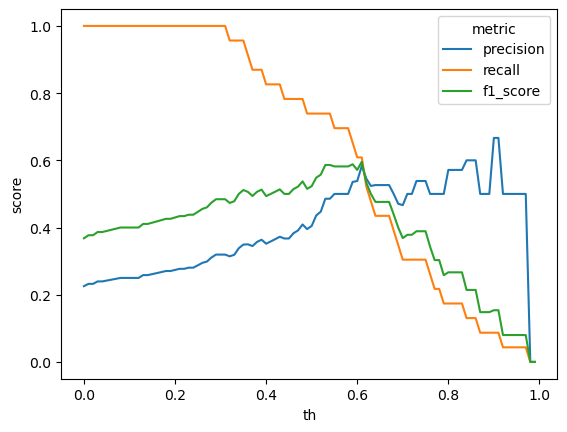

In [309]:
sns.lineplot(data=metrics, x="th", y="score", hue="metric")

In [ ]:
sns.metrics

In [250]:
np.max(arr)

0.47642988

In [194]:
metrics = {a}

th_list = np.arange(0, urban_zs_pred["sum"])

for th in th_list:

'/home/rustt/Documents/Projects/building_damage/morocco_damage_building/data/processed/dataset/png/data_labelled/labels/task-9-annotation-9-by-1-tag-damage_building-0.png'

In [ ]:
out_path_label = mask_array_to_geotiff()

In [ ]:
with rio.open(rs_pred) as src:
    for index, geom in enumerate(urban_test.geometry):
        feature = [mapping(geom)]

        # the mask function returns an array of the raster pixels within this feature
        out_image, out_transform = mask(src, feature, crop=True)
        # eliminate all the pixels with 0 values for all 8 bands - AKA not actually part of the shapefile
        out_image_trimmed = out_image[:, ~np.all(out_image == 0, axis=0)]

In [361]:
polygon_mask = rio.features.geometry_mask(geometries=[_ for _ in hex.geometry],
                                               out_shape=(rs_a.shape[0], 
                                                          rs_a.shape[1]),
                                               transform=rs_a.rio.transform(),
                                               all_touched=False,
                                               invert=True)

In [371]:
rs_pred.astype(np.uint16).shape

(1024, 1024)

In [355]:
rs_a = rioxr.open_rasterio(a_path)
rs_a.rio.transform()
zs = zonal_stats(f"hex_mask_{img_id}.shp", rs_pred, affine=rs_a.rio.transform())

In [281]:
hexagons.explore()

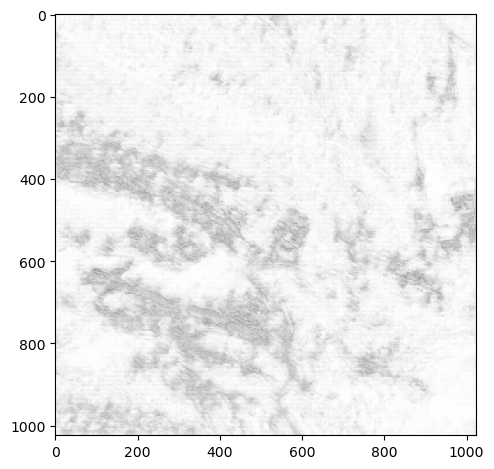

In [75]:
io.imshow(output)

In [57]:
test_set.columns

Index(['annotation_id', 'labels_path', 'img_id', 'after_path', 'before_path'], dtype='object')

In [ ]:
mask_batch = test_set["labels_path"].values
mask_batch = [io.imread(_) for _ in mask_batch]

batch = test_set[["before_path", "after_path"]].values

batch = [(io.imread(_[0]), io.imread(_[1])) for _ in batch]

output = []
for pre_img, post_img in batch:
    pre_img = torch.from_numpy(pre_img.transpose(2, 0, 1)).float().unsqueeze(0)
    post_img = torch.from_numpy(post_img.transpose(2, 0, 1)).float().unsqueeze(0)

    output.append(model(pre_img, post_img))

output = [_.detach().numpy() for _ in output]

output = [np.max(_, axis=1) for _ in output]
output = [_.squeeze(0) for _ in output]

output[0].shape

def sig(x):
 return 1/(1 + np.exp(-x))